# import liberaries and data

In [1]:
# import libararies
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("max_columns",0)


In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
# data sources
energy_csv = '/content/drive/MyDrive/Colab Notebooks/DS bootcamp- project 2/energy_dataset.csv' # location of dataset containing information about energy consumption in spain
weather_csv = '/content/drive/MyDrive/Colab Notebooks/DS bootcamp- project 2/weather_features.csv' # location of dataset containing information about weather in spain

# read as DataFrames
weather_df = pd.read_csv(weather_csv) # read weather_csv 
energy_df = pd.read_csv(energy_csv) # read energy_csv 

In [11]:
energy_df.shape

(35064, 29)

In [12]:
weather_df.shape

(178396, 17)

# getting rid of useless data

In [13]:
# a function that iterate over df columns and drops columns which are all null or contain only a single value
def remove_useless_cols(df):
  for col in df.columns:
    if df[col].nunique() <= 1:
      df.drop(columns = col, inplace = True)
  return df

In [14]:
# apply usless column filtration on both DataFrames and rename date columns
weather_df = remove_useless_cols(weather_df).rename(columns={'dt_iso':'time'})
energy_df =  remove_useless_cols(energy_df)

# data preperation

In [15]:
# apply datetime format on date time and date columns
weather_df['time'] = pd.to_datetime(weather_df['time'], infer_datetime_format = True, utc = True)
energy_df['time'] = pd.to_datetime(energy_df['time'], infer_datetime_format = True, utc = True)

In [16]:
# set energy waste as a negative value
energy_df['generation waste'] = energy_df['generation waste'].apply(lambda x: -1 * x)

In [17]:
# drop forcasting columns (will not be used in this work)
energy_df.drop(columns = ['forecast solar day ahead',
                          'forecast wind onshore day ahead',
                          'total load forecast'], 
                           inplace = True)

# data exploration - energy 

In [18]:
energy_df.head(3)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,-196.0,6378.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,-195.0,5890.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,-196.0,5461.0,22734.0,47.33,64.48


In [19]:
energy_df.shape

(35064, 18)

In [20]:
# filter only energy generation and energy waste columns
generation_cols = energy_df[[col for col in energy_df.columns if 'generation' in col]]

# create a column for the sum of all energy generation sources and waste
energy_df['sum energy sources'] = generation_cols.sum(1)

# create a column for the diffrence between total energy generation and total energy demand (total load actual)
energy_df['excess energy'] = energy_df['sum energy sources'] - energy_df['total load actual']


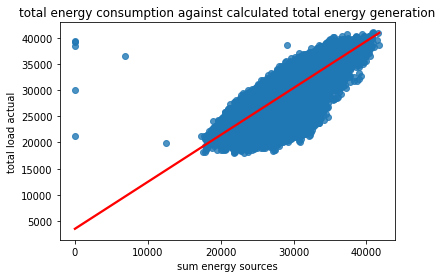

In [21]:
# plot the total energy consumption against calculated total energy generation
sns.regplot(data = energy_df, x = 'sum energy sources', y = 'total load actual', line_kws={'color': 'red'}).set(title='total energy consumption against calculated total energy generation')
plt.show()

In [22]:
# drop rows with extreamly low energy generation
energy_df.drop(energy_df[energy_df['sum energy sources'] < 10000].index, inplace = True)

In [23]:
# drop 2014 data
energy_df.drop(energy_df[energy_df.time.dt.year == 2014].index, inplace = True)

**Overall, total energy generation is in good correlation with total energy consumption**

There are several outliers that indicates very high consumption and very low generation. could be due to imperfect data or extream event. Such cases are removed. 

In [24]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35044 entries, 1 to 35063
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35044 non-null  datetime64[ns, UTC]
 1   generation biomass                           35043 non-null  float64            
 2   generation fossil brown coal/lignite         35044 non-null  float64            
 3   generation fossil gas                        35044 non-null  float64            
 4   generation fossil hard coal                  35044 non-null  float64            
 5   generation fossil oil                        35043 non-null  float64            
 6   generation hydro pumped storage consumption  35043 non-null  float64            
 7   generation hydro run-of-river and poundage   35043 non-null  float64            
 8   generation hydro water res

# data exploration - weather 

In [25]:
weather_df.head(3)

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [26]:
weather_df.shape

(178396, 17)

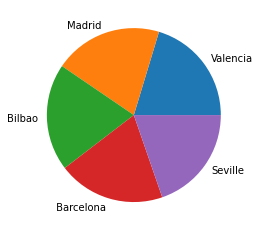

In [27]:
# the cities where weather measurements were made
plt.pie(weather_df['city_name'].value_counts(), labels = weather_df['city_name'].unique())
plt.show()

Data was equally collected from all cities.

In [28]:
# a function that gets wind direction in degrees (as int) and returns direction as string ('N', 'NE' ...)
def wind_direction(deg):
  if deg >= 337.5:
    deg -= 360
  directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
  angles =  [(x/10, (x+450)/10) for x in range(-225,3610,450)]
  for direction, angle in zip(directions, angles):
    if (deg >= angle[0]) & (deg <= angle[1]):
      return direction
    

In [29]:
weather_df['wind_deg'] = weather_df['wind_deg'].apply(wind_direction)

In [30]:
# drop rows from 2014
weather_df.drop(weather_df[weather_df.time.dt.year == 2014].index, inplace = True)

In [31]:
# drop data with exceptional pressure
weather_df.drop(weather_df[(weather_df.pressure > 1100)].index, inplace = True)
weather_df.drop(weather_df[(weather_df.pressure < 900)].index, inplace = True)


In [32]:
# drop Data with hourly rainfall above 10 mm in 05,06/06/2016
weather_df.drop(weather_df[(weather_df['rain_1h'] >= 12) &
                           (weather_df['time'].dt.year == 2016) &
                           (weather_df['time'].dt.month >= 5) &
                           (weather_df['time'].dt.month <= 8)].index, inplace = True)


In [33]:
#drop Data with exceptional wind speed
wind_speed_2017 = weather_df.time.dt.year == 2017
wind_speed_1_to_7 = (weather_df.time.dt.month >=1) & (weather_df.time.dt.month <=7)
rows_to_drop=weather_df[wind_speed_1_to_7 &  wind_speed_2017 & (weather_df['wind_speed'] > 100)].index
weather_df.drop(rows_to_drop, inplace = True)


In [34]:
fig=plt.figure(figsize=(45,12))
columns = 2
rows = 3

for ax, col in enumerate(['temp', 'pressure', 'humidity', 'rain_1h', 'clouds_all']):
   city_weather_by_day = weather_df.groupby([pd.Grouper(key='time', freq='D'), 'city_name']).agg({'temp' : 'mean',
                                                                                                    'pressure' : 'mean',
                                                                                                    'humidity' : 'mean',
                                                                                                    'rain_1h' : 'sum',
                                                                                                    'clouds_all' : 'mean'})
   fig.add_subplot(rows, columns, ax+1)
   sns.scatterplot(x='time', y=col, data=city_weather_by_day,hue='city_name')

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

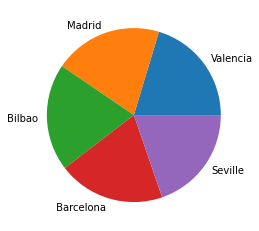

In [35]:
# the cities where weather measurements were made
plt.pie(weather_df['city_name'].value_counts(), labels = weather_df['city_name'].unique())
plt.show()

**Data of summer 2016 in barcelona is suspicouse**

The temperatures raise in summer and drop in the winter.

The humisity in Madrid and Seville (which are hotter) drop in the winter and rise in the summer while other cities are more consistant.

Bilbao is more cloudy all around the year while other cities have peaks in the winters.



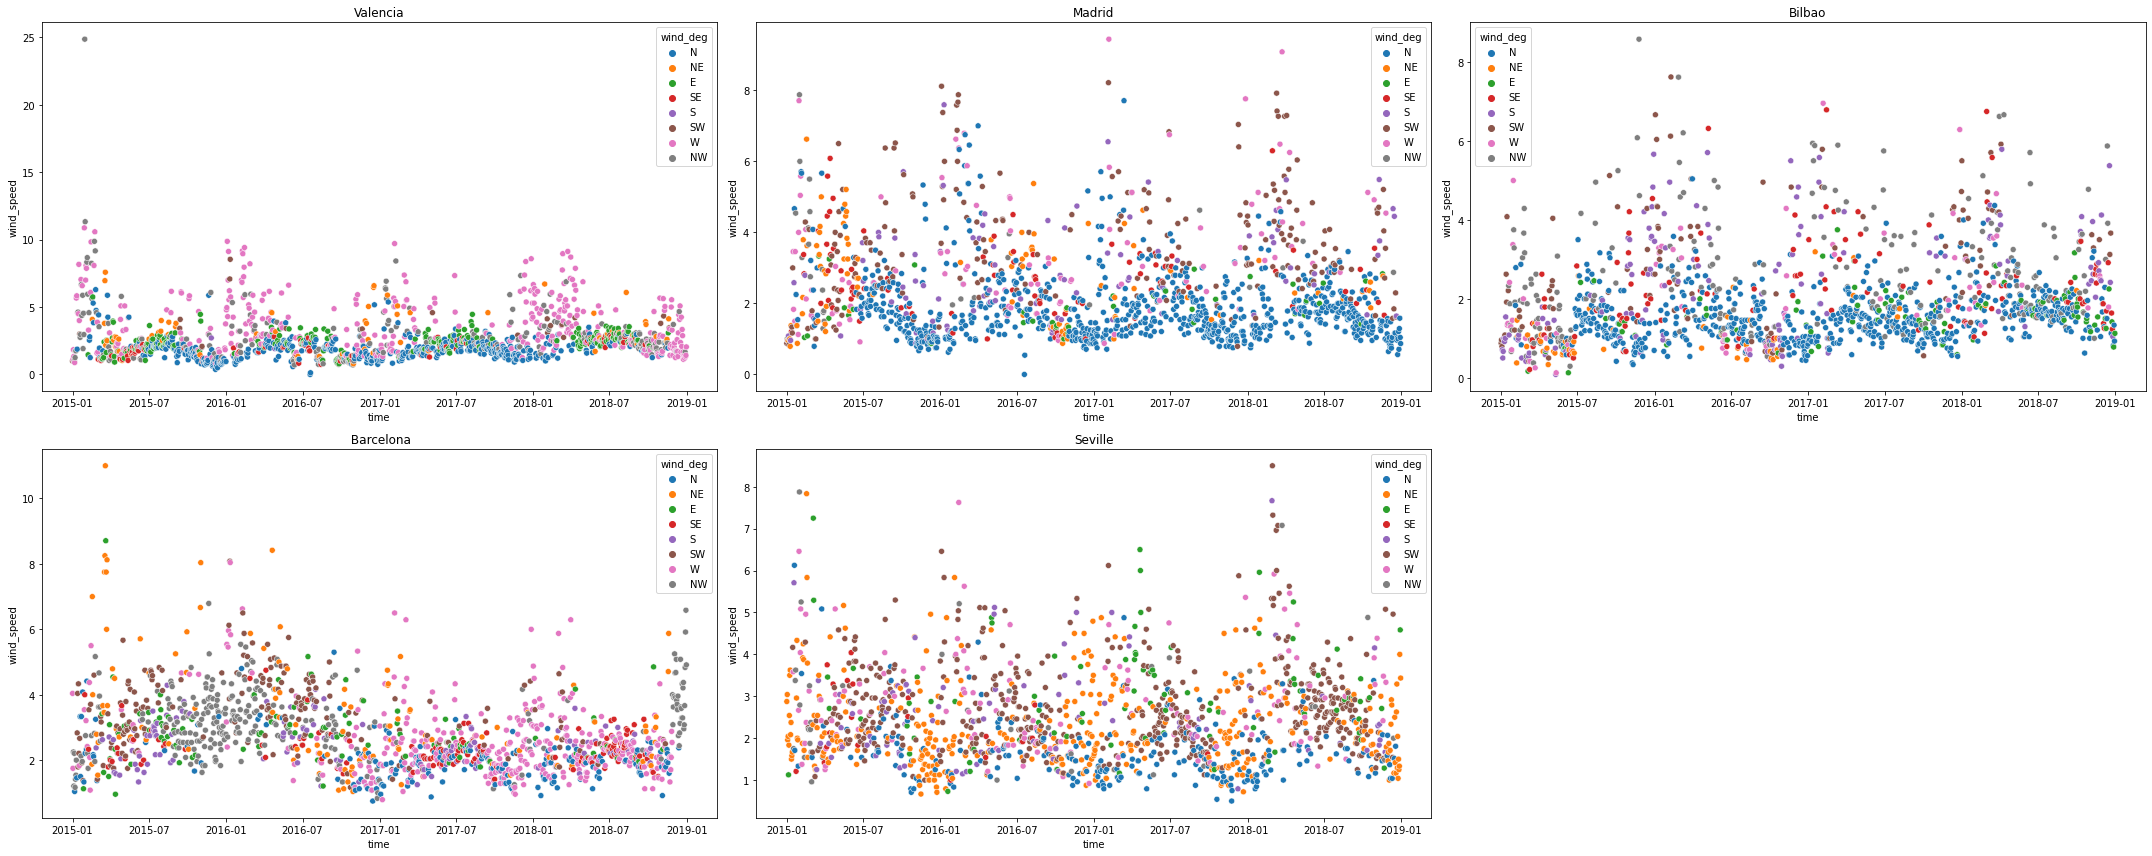

In [36]:
fig=plt.figure(figsize=(30,12))
columns = 3
rows = 2
for ax, city in enumerate(weather_df.city_name.unique()):
  city_winds = weather_df[weather_df.city_name == city][['time', 'wind_speed', 'wind_deg']]
  city_winds = city_winds.groupby([pd.Grouper(key='time', freq='D')]).agg({'wind_speed' : 'mean', 'wind_deg' : lambda x: x.value_counts().index[0]})
  fig.add_subplot(rows, columns, ax+1)
  sns.scatterplot(x='time',
                  y='wind_speed',
                  data=city_winds,
                  hue='wind_deg',
                  hue_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']).set_title(city)

plt.tight_layout()

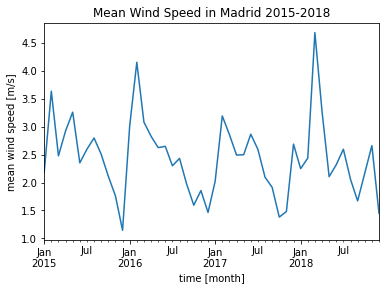

In [37]:
madrid_weather=weather_df[weather_df.city_name == 'Madrid']
madrid_idxtime=madrid_weather.set_index('time')
madrid_idxtime['wind_speed'].resample(rule='M').mean().plot(xlabel='time [month]',ylabel='mean wind speed [m/s]', title= 'Mean Wind Speed in Madrid 2015-2018')
plt.show()

Wind speed in Madrid and Bilbao is low around the winters and comes mainly from north, while stronger western and south-western winds blow in the summers.

Winds are usualy low in Valencia with directions of north in the summers and west in the winters. only in Valencia winter is clearly more windy.

Directions of wind in Barcelona are less predictable, and there was a shift in their direction and intensity at the begining of 2017.

Wind directions in Seville are mainly north and north-east in the winters and south, south-west and south-east in the summers.

In [38]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178332 entries, 1 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   time                 178332 non-null  datetime64[ns, UTC]
 1   city_name            178332 non-null  object             
 2   temp                 178332 non-null  float64            
 3   temp_min             178332 non-null  float64            
 4   temp_max             178332 non-null  float64            
 5   pressure             178332 non-null  int64              
 6   humidity             178332 non-null  int64              
 7   wind_speed           178332 non-null  int64              
 8   wind_deg             178332 non-null  object             
 9   rain_1h              178332 non-null  float64            
 10  rain_3h              178332 non-null  float64            
 11  snow_3h              178332 non-null  float64            
 12  cl

#Questions:

**Hypothesis** - Weather factors affect energy consumption and generation, which affect energy prices

1. How energy consumption, generation and price change across time?
2. How total energy consumtion and generation affect energy price?
3. How the energy sources are used across time, and what their effect on energy prices?
3. What weather parameters affect energy consumption and generation?
4. Is there a shift in the use of different energy sources in different weather conditions?
5. Is weather in specific areas more significant to energy consumption and generation?
6. How weather changes across Spain (at different cities)?
7. Are there specific weather conditions, in specific areas, that correlate with increased/decreased generation of energy from a certain source?
8. What are the factors that affect energy prices?




# 1. energy generation, consumption and price as function of time

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
No handles with labels found to put in legend.


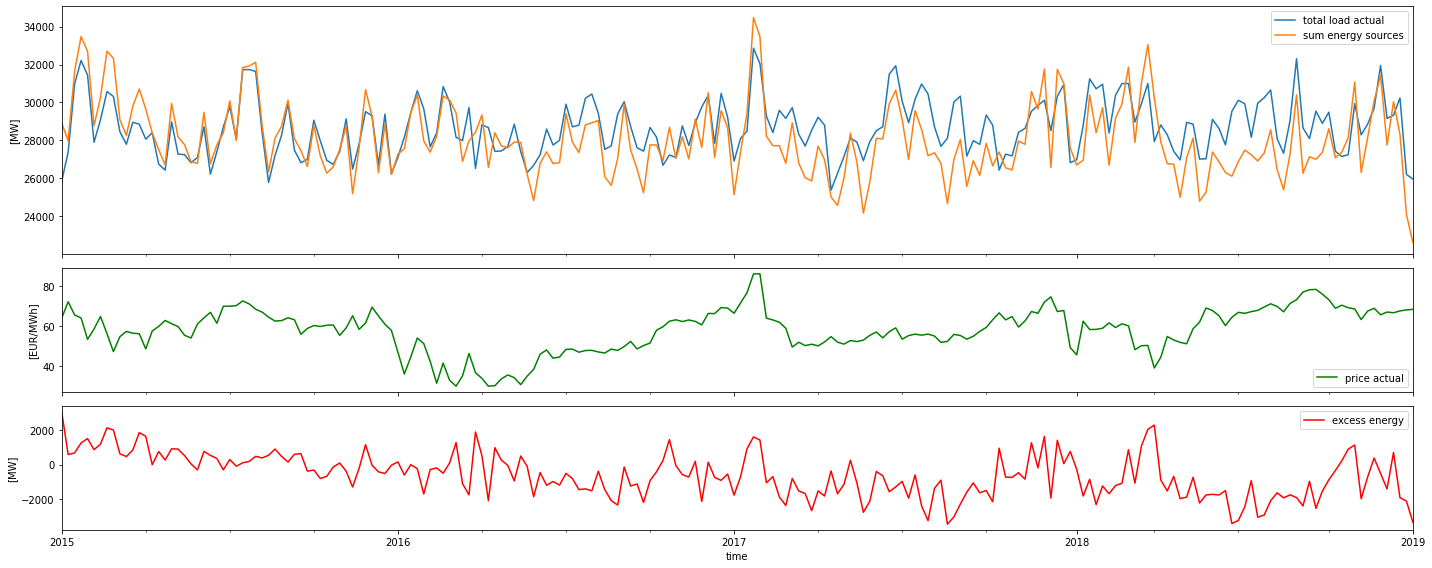

In [39]:
#plot energy consumption, generation and price as function of time

fig , axes = plt.subplots(3,1, figsize = (20,8), sharex = True,  gridspec_kw={'height_ratios': [2,1, 1]})
energy_per_month = energy_df.groupby(energy_df.time.dt.to_period('W')).mean()

energy_per_month[['total load actual',
                  'sum energy sources']
                  ].plot(legend = True,
                   ylabel= '[MW]',      
                   ax = axes[0])

axes[1].legend(loc = 'upper right')
energy_per_month['price actual'].plot(
                                      style = 'g',
                                      legend = True,
                                      ylabel= '[EUR/MWh]',
                                      ax = axes[1])

energy_per_month['excess energy'].plot(
                                      style = 'r',
                                      legend = True,
                                      ylabel= '[MW]',
                                      ax = axes[2])


axes[1].legend(loc = 'lower right')

plt.tight_layout()

**Energy consumption and generation seem to have peaks around the summers and the winters. energy prices seem to generaly raise in the same times.**

The difference between energy generation and consumption doesn't seem to explain better energy prices.

# 2. energy price as function of energy generation, consumption and waste




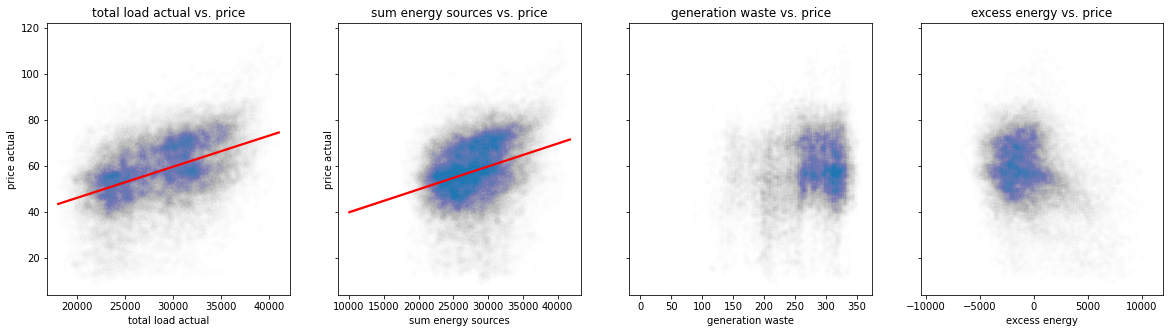

In [41]:
# plot the total energy consumption, generation and waste against energy prices
fig, axes = plt.subplots(1,4, figsize = (20,5), sharey = True)
sns.regplot(data = energy_df, x = 'total load actual', y = 'price actual', ax = axes[0],  line_kws={'color': 'red'}, scatter_kws = {'alpha' : 0.005})
axes[0].set_title('total load actual vs. price')
sns.regplot(data = energy_df, x = 'sum energy sources', y = 'price actual', line_kws={'color': 'red'}, ax = axes[1], scatter_kws = {'alpha' : 0.005})
axes[1].set_title('sum energy sources vs. price')
sns.scatterplot(data = energy_df, x = energy_df['generation waste'] * -1, y = 'price actual', ax = axes[2], alpha= 0.005)
axes[2].set_title('generation waste vs. price')
sns.scatterplot(data = energy_df, x = 'excess energy', y = 'price actual',  alpha= 0.005)
axes[3].set_title('excess energy vs. price')
plt.show()

**The energy price seems to rise when total consumption and production of energy increase.**

It apears that energy consumption and generation are increased usually around 20,000-35,000 MW and that are two main levels of energy cunsumption (around 24,000 and around 31,000 MW).





# 3. different energy sources usege as function of time and their effect on energy prices

In [42]:
# create a dataframe of only energy sources
sources = energy_df.drop(columns = ['generation waste',
                          'total load actual',
                          'sum energy sources', 
                          'price actual',
                          'excess energy',
                          'sum energy sources',
                          'price day ahead']
                          )

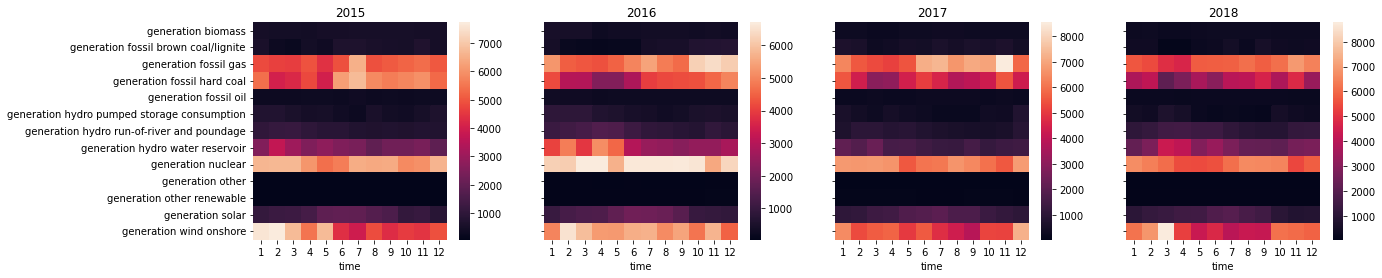

In [43]:
# plot a heatmap of the use of each energy source per month and year
fig, axes = plt.subplots(1,4, figsize = (20,4) , sharey = True)
for ax, year in enumerate(sources.time.dt.year.unique()):
  sources_b_year = sources[sources.time.dt.year == year]
  sources_by_months = sources_b_year.groupby(sources.time.dt.month).mean().transpose()
  sns.heatmap(sources_by_months, ax = axes[ax])
  axes[ax].set_title(year)


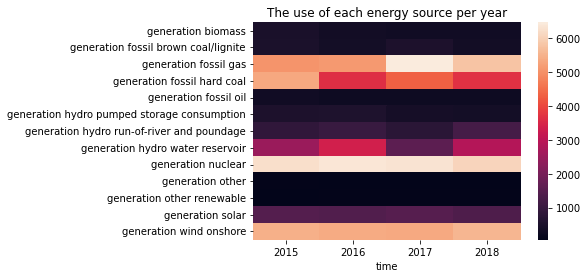

In [44]:
# plot a heatmap of the use of each energy source per year
sources_by_years = sources.groupby(sources.time.dt.year).mean().transpose()
sns.heatmap(sources_by_years)
plt.title('The use of each energy source per year')
plt.show()

**The predominant energy sources are fossil gass and hard coal, hydro 
water reservoir, nuclear and wind.**

at 2017 there was an increase in the usage of fossil gas and hard coal,
and a decease in usage of hydro sources (reservoir and river pondage).

over the years there was a decreace of use in fossil hard coal and nuclear energy.

the usege of fossil gass and hard coal seem to correlate and is more significant around june-december.

the usege of hydro water reservoir and wind energy seem to correlate and is more significant around october-march.

the usege of solar energy is more significant around may-september.

the usege of nuclear energy is more significant around the peak of the summer and the peak of the winter (june-september, december-march).


In [45]:
# filter only predominant energy sources for further analysis
dom_energy_df = energy_df[['time',
                          'generation fossil gas',
                          'generation fossil hard coal',
                          'generation hydro water reservoir',
                          'generation nuclear',
                          'generation solar',
                          'generation wind onshore',
                          'sum energy sources',
                          'price actual']]


In [46]:
dom_sources = dom_energy_df.copy()

In [47]:
# convert values to relative amount from total energy generation
for col in dom_energy_df.columns[1:-1]:
  dom_energy_df[col] = dom_energy_df[col]/dom_energy_df['sum energy sources']
dom_energy_df.drop(columns = ['sum energy sources'], inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


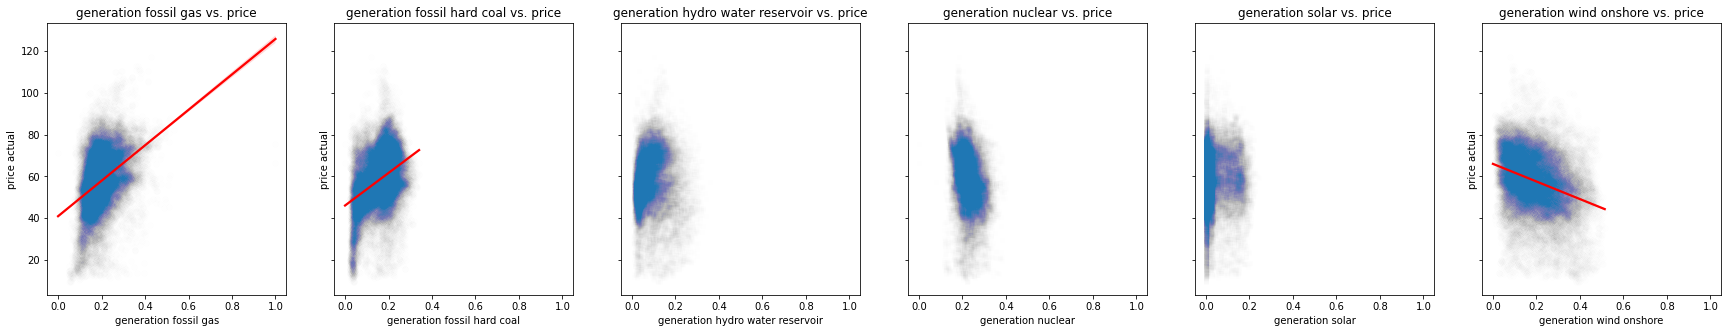

In [48]:
# plot relative use energy sources vs. total energy price
fig, axes = plt.subplots(1,6, figsize = (30,5), sharey = True, sharex = True)

for ax, source in enumerate(dom_energy_df.columns[1:-1]):
  if (ax == 0) or (ax == 1) or (ax == 5):
    sns.regplot(data = dom_energy_df, x = source, y = 'price actual', ax = axes[ax],  line_kws={'color': 'red'}, scatter_kws = {'alpha' : 0.005})
  else:
    sns.scatterplot(data = dom_energy_df, x = source, y = 'price actual', ax = axes[ax], alpha = 0.005)
  axes[ax].set_title(f'{source} vs. price')

**Energy generation using generation fossil gas and fossil hard coal seem to increase total energy price while energy generation using wind seem to reduce energy generation price.**

solar and hydro water reservoir energy generation seem to be limited to ~20% of energy production while nuclear energy is never less than ~20%. 

# 4. energy consumption, total generation, sources usage and price as function of weather in different cities

In [49]:
energy = pd.merge(dom_sources , energy_df[['time', 'total load actual']], how = 'inner', on = 'time')
merge_df = pd.merge(weather_df, energy, how='inner', on='time')


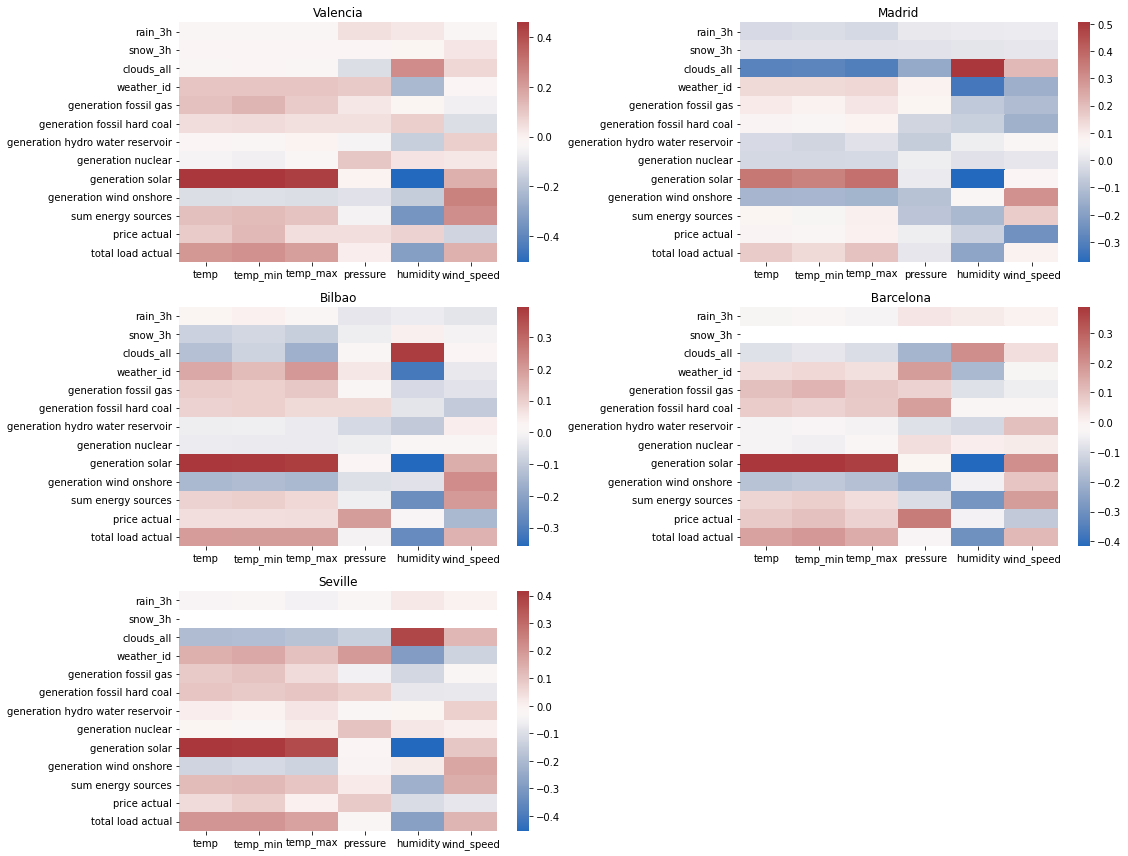

In [50]:
fig=plt.figure(figsize=(16,12))
columns = 2
rows = 3
for ax, city in enumerate(merge_df.city_name.unique()):
  city_merge = merge_df[merge_df.city_name == city]
  merge_corr = city_merge.corr().drop(columns = merge_df.corr().columns[6:])[7:]
  fig.add_subplot(rows, columns, ax+1)
  sns.heatmap(merge_corr, cmap = "vlag").set_title(city)

plt.tight_layout()


- solar generation is positively correlated with temperature and negatively with humidity across all cities.

- it seems that in general the relationship between weather and energy parameter is simillar in all cities.

- wind energy generation and total energy generation seem to positively correlate with wind speed, and to negatively correlate with hard coal energy generation, and price (especially in madrid)

- price is seem negatively correlated with wind speed especially in madrid.





In [51]:
merge_by_day = merge_df.groupby([pd.Grouper(key='time', freq='W'), 'city_name']).agg({'temp' : 'mean',
                                                                        'pressure' : 'mean',
                                                                        'humidity' : 'mean',
                                                                        'rain_1h' : 'sum',
                                                                        'clouds_all' : 'mean',
                                                                        'generation fossil hard coal': 'sum',
                                                                        'generation hydro water reservoir' : 'sum',	
                                                                        'generation nuclear': 'sum',
                                                                        'generation solar': 'sum',
                                                                        'generation wind onshore': 'sum',	
                                                                        'price actual': 'mean',
                                                                        'total load actual': 'sum',	
                                                                        'sum energy sources': 'sum',
                                                                        'wind_speed' : 'mean',
                                                                        'wind_deg' : lambda x: x.value_counts().index[0]}).reset_index('city_name')
                                                  

In [52]:
# a function that create regplot with hue argument
def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    from matplotlib.cm import get_cmap
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                **kwargs
            )
        )
    
    return regplots


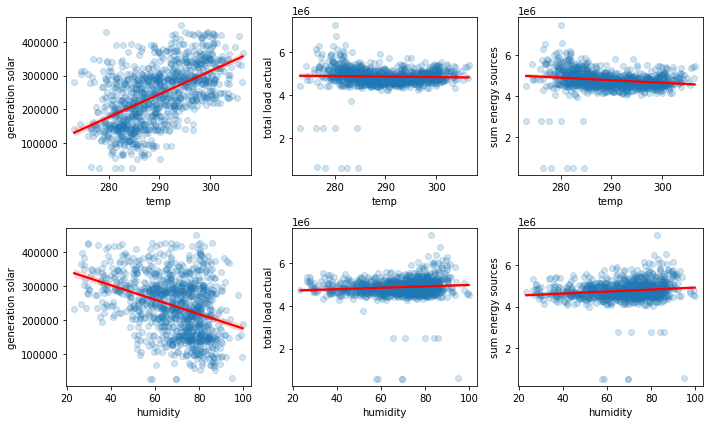

In [53]:
fig, axes = plt.subplots(2,3, figsize = (10,6))

for row, yvar in enumerate(['generation solar', 'total load actual', 'sum energy sources']):
  for col, xvar in enumerate(['temp', 'humidity']):
    sns.regplot(data = merge_by_day,
                          x = xvar,
                          y = yvar,
                          line_kws={'color': 'red'},
                          # hue = 'city_name',
                          ax = axes[col, row],
                           scatter_kws = {'alpha' : 0.2})

plt.tight_layout()


solar energy generation is increased with highr temperture and decrease with higher humidity, in all cities.

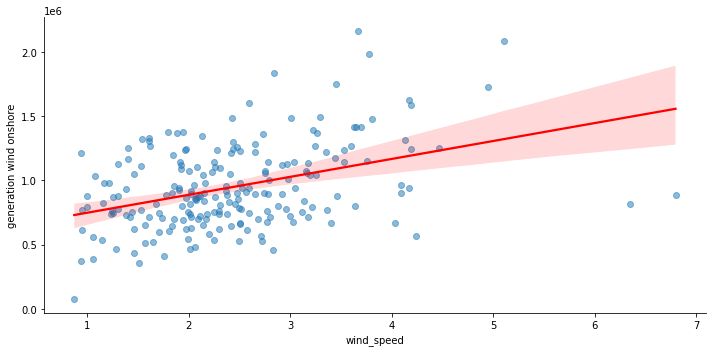

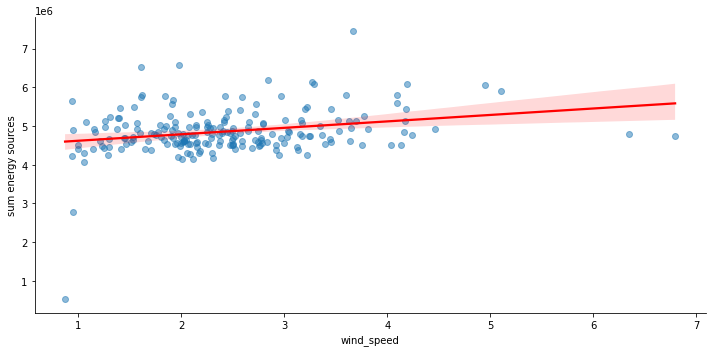

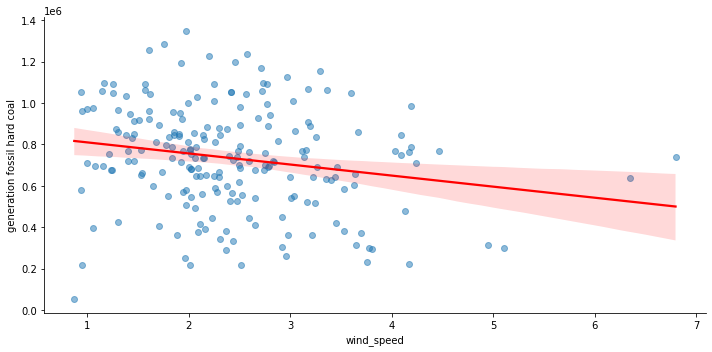

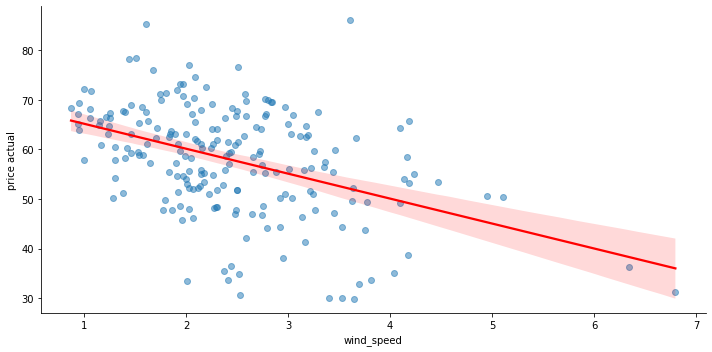

In [54]:
for ax, yvar in enumerate(['generation wind onshore', 
                           'sum energy sources', 
                           'generation fossil hard coal',
                           'price actual']):
  

  sns.lmplot(data = merge_by_day[merge_by_day.city_name == 'Madrid'],
                          x = 'wind_speed',
                          y = yvar,
                          height = 5,
                          aspect = 2,
                          line_kws={'color': 'red'},
                          scatter_kws = {'alpha' : 0.5})


**Wind energy generation is increased with higher wind speed, especially in madrid.**

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


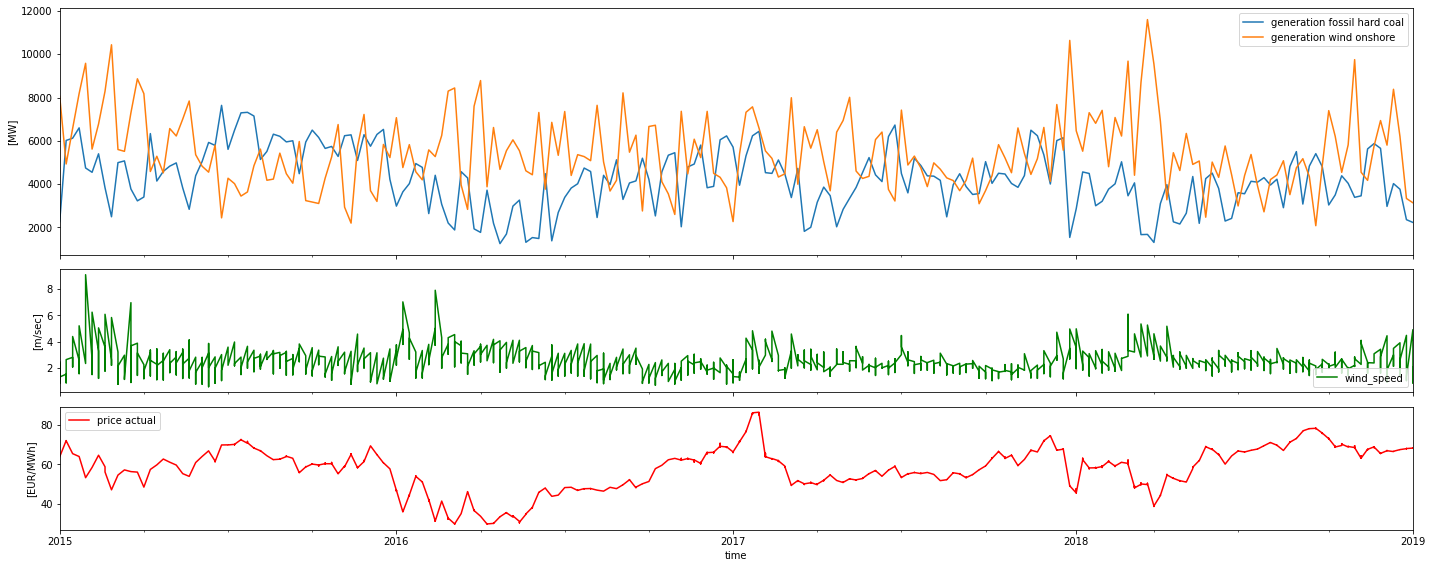

In [59]:
#plot energy consumption, generation and price as function of time

fig , axes = plt.subplots(3,1, figsize = (20,8), sharex = True,  gridspec_kw={'height_ratios': [2,1, 1]})
energy_per_month = energy_df.groupby(energy_df.time.dt.to_period('W')).mean()

energy_per_month[['generation fossil hard coal',
                  'generation wind onshore']
                  ].plot(legend = True,
                   ylabel= '[MW]',      
                   ax = axes[0])

axes[1].legend(loc = 'upper right')
merge_by_day['wind_speed'].plot(
                                      style = 'g',
                                      legend = True,
                                      ylabel= '[m/sec]',
                                      ax = axes[1])

merge_by_day['price actual'].plot(
                                      style = 'r',
                                      legend = True,
                                      ylabel= '[EUR/MWh]',
                                      ax = axes[2])


axes[1].legend(loc = 'lower right')

plt.tight_layout()

With higher wind speeds, more energy is generated from wind and less hard coal is burnt, therefore energy prices drop.